In [3]:
import importlib.util
import os
from pyspark.sql.functions import broadcast
import os
import pwd
import numpy as np
import sys
import pandas as pd
from pyspark.sql import SparkSession
from random import randrange
import pyspark.sql.functions as F
#np.bool = np.bool_
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler)
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import rank, col, avg, hour, minute, date_format, count, year, when, expr, coalesce, lit, round
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.metrics         import mean_squared_error, r2_score
import base64 as b64
import json
import time
import re
import warnings
import trino
from contextlib import closing
from urllib.parse import urlparse
from trino.dbapi import connect
from trino.auth import BasicAuthentication, JWTAuthentication
import matplotlib.pyplot as plt
import plotly.express as px
import calendar
from matplotlib import cm
from matplotlib.colors import Normalize


# Load preprocessing module
spec = importlib.util.spec_from_file_location("utils", '../scripts/preprocessing.py')
preprocess = importlib.util.module_from_spec(spec)
spec.loader.exec_module(preprocess)
print(preprocess.test())

Imported successfully!


In [4]:
#setup spark session and trino
username = pwd.getpwuid(os.getuid()).pw_name
hadoopFS=os.getenv('HADOOP_FS', None)
groupName = 'U1'
print(os.getenv('SPARK_HOME'))
print(f"hadoopFSs={hadoopFS}")
print(f"username={username}")
print(f"group={groupName}")

spark = SparkSession\
            .builder\
            .appName(pwd.getpwuid(os.getuid()).pw_name)\
            .config('spark.ui.port', randrange(4040, 4440, 5))\
            .config("spark.executorEnv.PYTHONPATH", ":".join(sys.path)) \
            .config('spark.jars', f'{hadoopFS}/data/com-490/jars/iceberg-spark-runtime-3.5_2.13-1.6.1.jar')\
            .config('spark.sql.extensions', 'org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions')\
            .config('spark.sql.catalog.iceberg', 'org.apache.iceberg.spark.SparkCatalog')\
            .config('spark.sql.catalog.iceberg.type', 'hadoop')\
            .config('spark.sql.catalog.iceberg.warehouse', f'{hadoopFS}/data/com-490/iceberg/')\
            .config('spark.sql.catalog.spark_catalog', 'org.apache.iceberg.spark.SparkSessionCatalog')\
            .config('spark.sql.catalog.spark_catalog.type', 'hadoop')\
            .config('spark.sql.catalog.spark_catalog.warehouse', f'{hadoopFS}/user/{username}/assignment-3/warehouse')\
            .config("spark.sql.warehouse.dir", f'{hadoopFS}/user/{username}/assignment-3/spark/warehouse')\
            .config('spark.eventLog.gcMetrics.youngGenerationGarbageCollectors', 'G1 Young Generation')\
            .config("spark.executor.memory", "6g")\
            .config("spark.executor.cores", "4")\
            .config("spark.executor.instances", "4")\
            .master('yarn')\
            .getOrCreate()

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="pandas only supports SQLAlchemy connectable .*")



def getUsername():
    payload = os.environ.get('EPFL_COM490_TOKEN').split('.')[1]
    payload=payload+'=' * (4 - len(payload) % 4)
    obj = json.loads(b64.urlsafe_b64decode(payload))
    if (time.time() > int(obj.get('exp')) - 3600):
        raise Exception('Your credentials have expired, please restart your Jupyter Hub server:'
                        'File>Hub Control Panel, Stop My Server, Start My Server.')
    time_left = int((obj.get('exp') - time.time())/3600)
    return obj.get('sub'), time_left

username, validity_h = getUsername()
hadoopFS = os.environ.get('HADOOP_FS')
namespace = 'iceberg.' + username
sharedNS = 'iceberg.com490_iceberg'

if not re.search('[A-Z][0-9]', groupName):
    raise Exception('Invalid group name {groupName}')

print(f"you are: {username}")
print(f"credentials validity: {validity_h} hours left.")
print(f"shared namespace is: {sharedNS}")
print(f"your namespace is: {namespace}")
print(f"your group is: {groupName}")

trinoAuth = JWTAuthentication(os.environ.get('EPFL_COM490_TOKEN'))
trinoUrl  = urlparse(os.environ.get('TRINO_URL'))
Query=[]

print(f"Warehouse URL: {trinoUrl.scheme}://{trinoUrl.hostname}:{trinoUrl.port}/")

conn = connect(
    host=trinoUrl.hostname,
    port=trinoUrl.port,
    auth=trinoAuth,
    http_scheme=trinoUrl.scheme,
    verify=True
)

print('Connected!')

/opt/spark
hadoopFSs=hdfs://iccluster059.iccluster.epfl.ch:9000
username=omanovic
group=U1


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/26 09:01:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


you are: omanovic
credentials validity: 165 hours left.
shared namespace is: iceberg.com490_iceberg
your namespace is: iceberg.omanovic
your group is: U1
Warehouse URL: https://iccluster028.iccluster.epfl.ch:8443/
Connected!


In [27]:
stops_geo_df = spark.read.option("header", True).csv(f"{hadoopFS}/user/{username}/final/data/stops")
stops_geo_df.show(1)

+-------+--------------------+--------------------+--------------------+--------------------+
|stop_id|           stop_name|            stop_lon|            stop_lat|                uuid|
+-------+--------------------+--------------------+--------------------+--------------------+
|8592097|Lausanne, Pont Ma...|6.618095310000000000|46.51903701000000...|fa8f5deb-65a9-45c...|
+-------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [3]:
df_delays_with_weather = spark.read.option("header", True).csv(f"{hadoopFS}/user/{username}/final/data/delays_with_weather")

stops_geo_df = spark.read.option("header", True).csv(f"{hadoopFS}/user/{username}/final/data/stops")

with_names = df_delays_with_weather.join(broadcast(stops_geo_df.select("stop_id", "stop_name")),on="stop_id",how="left")

df_final= with_names.dropDuplicates()

In [4]:
df_final.show(5)

+-------+-------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+-------------------+
|stop_id|operating_day|dow|             trip_id|            arr_time|          arr_actual|            dep_time|          dep_actual|arr_delay_sec|dep_delay_sec|site|total_daily_precip|rained|          stop_name|
+-------+-------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+-------------------+
|8589525|   2024-08-06|  3|85:151:TL046-4506...|2024-08-06T11:46:...|2024-08-06T11:46:...|2024-08-06T11:46:...|2024-08-06T11:46:...|           16|           16|LSGL|               0.0| false|Epalinges, Planches|
|8592045|   2024-08-02|  6|85:151:TL013-4506...|2024-08-02T09:30:...|2024-08-02T09:31:...|2024-08-02T09:30:...|2024-08-02T09:31:...|           64|      

# Day of the week

/tmp/ipykernel_2146660/1630728078.py:31: MatplotlibDeprecationWarning:          

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



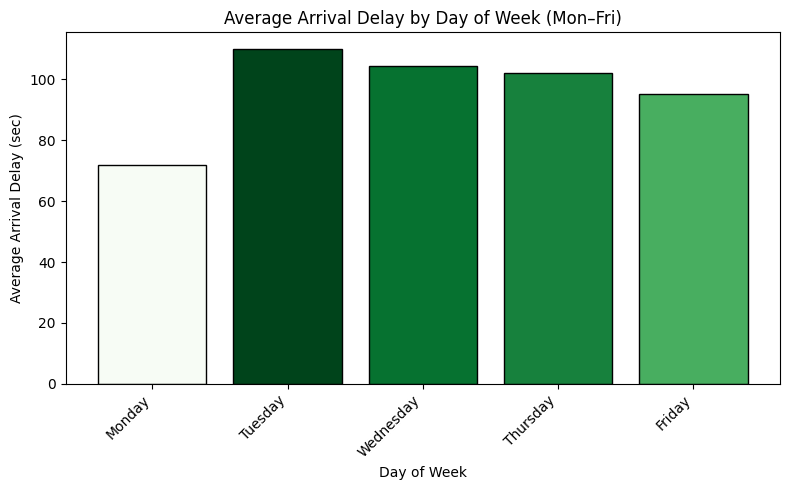

25/05/22 09:52:25 ERROR YarnScheduler: Lost executor 12 on iccluster093.iccluster.epfl.ch: Container marked as failed: container_e02_1747371376986_0849_01_000013 on host: iccluster093.iccluster.epfl.ch. Exit status: -100. Diagnostics: Container released on a *lost* node.
25/05/22 09:52:25 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 12 for reason Container marked as failed: container_e02_1747371376986_0849_01_000013 on host: iccluster093.iccluster.epfl.ch. Exit status: -100. Diagnostics: Container released on a *lost* node.


In [69]:
df_num = df_final.withColumn("arr_delay_sec", col("arr_delay_sec").cast("double"))

# average delay for each day of the week
dow_delay = (df_num.groupBy("dow").agg(round(avg("arr_delay_sec"),1).alias("avg_delay_sec")).orderBy("dow"))

pdf = dow_delay.toPandas()

pdf["dow"] = pdf["dow"].astype(int)

spark_to_name = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday",
}
pdf["weekday"] = pdf["dow"].map(spark_to_name)

pdf = pdf[pdf["dow"].between(2, 6)]

x_pos    = list(range(len(pdf)))
x_labels = pdf["weekday"].tolist()
y_values = pdf["avg_delay_sec"].tolist()

labels = pdf["weekday"].tolist()
values = pdf["avg_delay_sec"]

norm   = Normalize(vmin=values.min(), vmax=values.max())
cmap   = cm.get_cmap("Greens")
colors = cmap(norm(values))

plt.figure(figsize=(8,5))
plt.bar(range(len(labels)), values, color=colors, edgecolor="black", linewidth=1)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.xlabel("Day of Week")
plt.ylabel("Average Arrival Delay (sec)")
plt.title("Average Arrival Delay by Day of Week (Mon–Fri)")
plt.tight_layout()
plt.savefig("../figures/avg_delay_dayofweek.png",dpi=300)
plt.show()

# Time of the day

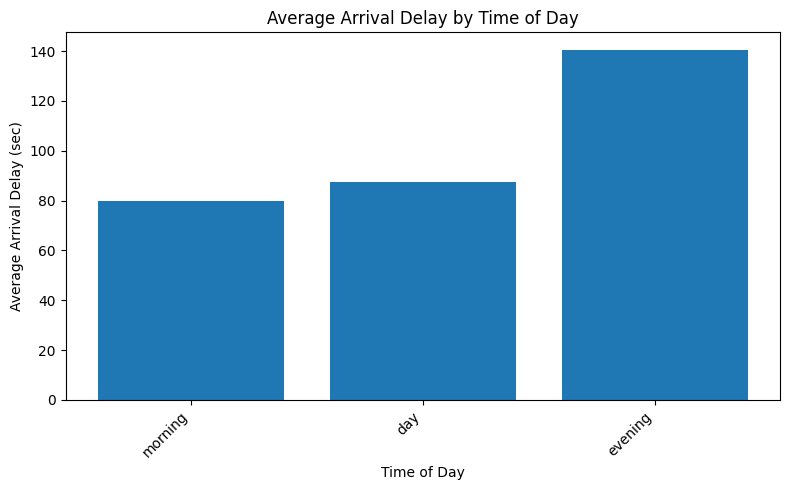

In [24]:
df2 = df_final.withColumn("arr_delay_sec", col("arr_delay_sec").cast("double"))

df2 = df2.withColumn(
    "dep_hour_dec",
    hour("dep_time") + minute("dep_time")/60.0
)

df2 = df2.withColumn(
    "time_of_day",
    when((col("dep_hour_dec") >= 7.0)  & (col("dep_hour_dec") <  9.5), "morning")
   .when((col("dep_hour_dec") >= 9.5)  & (col("dep_hour_dec") < 16.0), "day")
   .when((col("dep_hour_dec") >= 16.0) & (col("dep_hour_dec") < 19.0), "evening")
   .otherwise("other")
)

df2 = df2.filter(col("time_of_day").isin("morning","day","evening"))

tod_delay = (
    df2
      .groupBy("time_of_day")
      .agg(round(avg("arr_delay_sec"), 1).alias("avg_delay_sec"))
)

pdf_tod = tod_delay.toPandas()
order = ["morning","day","evening"]
pdf_tod["time_of_day"] = pd.Categorical(pdf_tod["time_of_day"], categories=order, ordered=True)
pdf_tod = pdf_tod.sort_values("time_of_day")

x_pos    = list(range(len(pdf_tod)))
x_labels = pdf_tod["time_of_day"].tolist()
y_values = pdf_tod["avg_delay_sec"].tolist()

plt.figure(figsize=(8,5))
plt.bar(x_pos, y_values)
plt.xticks(x_pos, x_labels, rotation=45, ha="right")
plt.xlabel("Time of Day")
plt.ylabel("Average Arrival Delay (sec)")
plt.title("Average Arrival Delay by Time of Day")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2146660/1704569462.py:18: MatplotlibDeprecationWarning:          

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



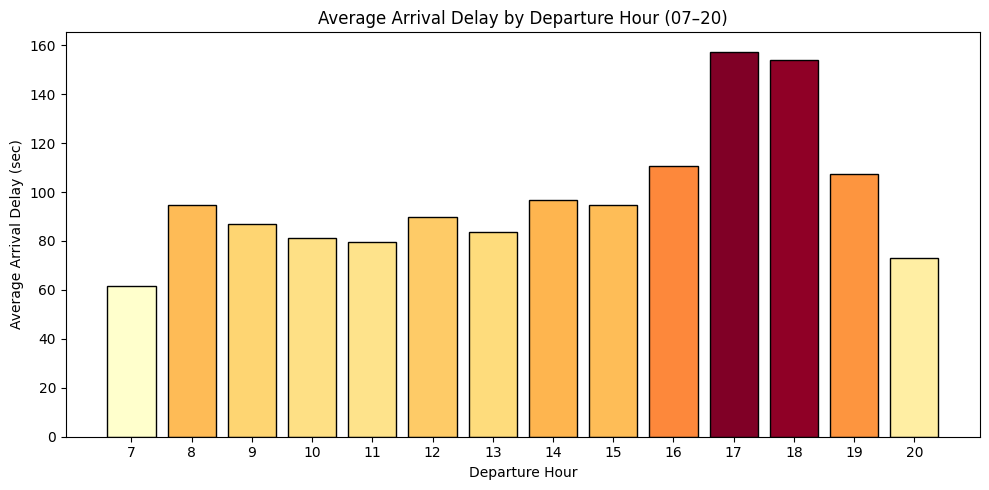

In [68]:
# avg delay by hour
df2 = df_final.withColumn("arr_delay_sec", col("arr_delay_sec").cast("double"))

df_hours = (
    df2
    .withColumn("dep_hour", hour("dep_time"))
    .groupBy("dep_hour")
    .agg(round(avg("arr_delay_sec"),1).alias("avg_delay_sec"))
    .filter(col("dep_hour").between(7,20))
    .orderBy("dep_hour")
)

pdf_hours = df_hours.toPandas()

# 2) Build a yellow→red colormap based on the delay values
values = pdf_hours["avg_delay_sec"]
norm   = Normalize(vmin=values.min(), vmax=values.max())
cmap   = cm.get_cmap("YlOrRd")
colors = cmap(norm(values))

# 3) Plot with those colors
plt.figure(figsize=(10,5))
plt.bar(pdf_hours["dep_hour"], pdf_hours["avg_delay_sec"], color=colors, edgecolor="black", linewidth=1)
plt.xticks(range(7,21))
plt.xlabel("Departure Hour")
plt.ylabel("Average Arrival Delay (sec)")
plt.title("Average Arrival Delay by Departure Hour (07–20)")
plt.tight_layout()
plt.savefig("../figures/avg_delay_departurehour.png",dpi=300)
plt.show()


In [44]:
df_final.show(1)

+-------+-------------+---+-----------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+-----------------+
|stop_id|operating_day|dow|    trip_id|            arr_time|          arr_actual|            dep_time|          dep_actual|arr_delay_sec|dep_delay_sec|site|total_daily_precip|rained|        stop_name|
+-------+-------------+---+-----------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+-----------------+
|8592062|   2024-11-07|  5|85:151:7151|2024-11-07T19:11:...|2024-11-07T19:13:...|2024-11-07T19:11:...|2024-11-07T19:14:...|          178|          200|LSGL|               0.0| false|Lausanne, Jurigoz|
+-------+-------------+---+-----------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+--------------

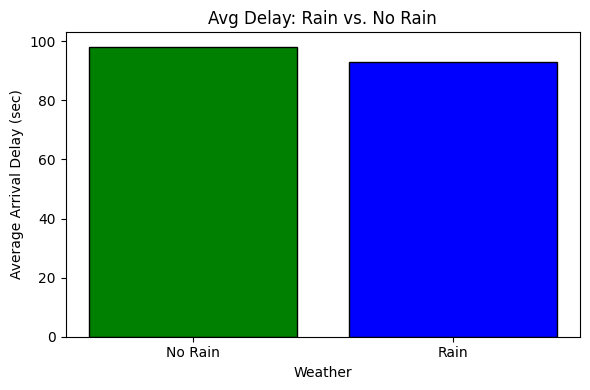

In [67]:


df2 = df_final.withColumn("arr_delay_sec", col("arr_delay_sec").cast("double"))

df2 = df2.withColumn(
    "rain_status",
    when(col("rained") == True, "Rain").otherwise("No Rain")
)


rain_delay = (
    df2
      .groupBy("rain_status")
      .agg(round(avg("arr_delay_sec"),1).alias("avg_delay_sec"))
)

pdf_rain = rain_delay.toPandas().sort_values("rain_status")

color_map = {"No Rain":"green", "Rain":"blue"}
colors = pdf_rain["rain_status"].map(color_map).tolist()

plt.figure(figsize=(6,4))
plt.bar(pdf_rain["rain_status"], pdf_rain["avg_delay_sec"], color=colors, edgecolor="black", linewidth=1)
plt.xlabel("Weather")
plt.ylabel("Average Arrival Delay (sec)")
plt.title("Avg Delay: Rain vs. No Rain")
plt.savefig("../figures/avg_delay_rainvsnorain.png",dpi=300)
plt.tight_layout()
plt.show()


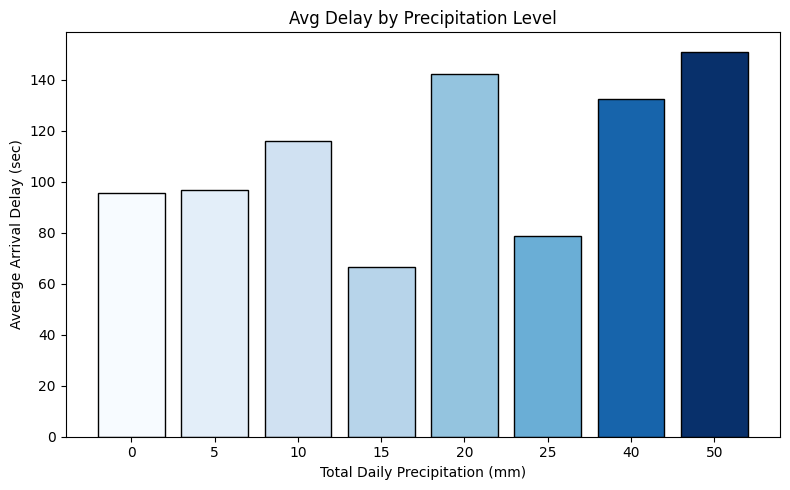

In [66]:


# 1) Cast to numeric
df2 = (
    df_final
      .withColumn("arr_delay_sec", col("arr_delay_sec").cast("double"))
      .withColumn("total_daily_precip", col("total_daily_precip").cast("double"))
)

# 2) Bucket into the specified precip‐groups
df2 = df2.withColumn(
    "precip_group",
    when(col("total_daily_precip") <= 0, 0)
   .when((col("total_daily_precip") > 0)  & (col("total_daily_precip") <= 5), 5)
   .when((col("total_daily_precip") > 5)  & (col("total_daily_precip") <= 10), 10)
   .when((col("total_daily_precip") > 10) & (col("total_daily_precip") <= 15), 15)
   .when((col("total_daily_precip") > 15) & (col("total_daily_precip") <= 20), 20)
   .when((col("total_daily_precip") > 20) & (col("total_daily_precip") <= 25), 25)
   .when((col("total_daily_precip") > 25) & (col("total_daily_precip") <= 30), 30)
   .when((col("total_daily_precip") > 30) & (col("total_daily_precip") <= 40), 40)
   .when((col("total_daily_precip") > 40) & (col("total_daily_precip") <= 50), 50)
   .otherwise(50)
)

# 3) Compute avg delay per bin
precip_delay = (
    df2
      .groupBy("precip_group")
      .agg(round(avg("arr_delay_sec"),1).alias("avg_delay_sec"))
      .orderBy("precip_group")
)

pdf_precip = precip_delay.toPandas()

groups = pdf_precip["precip_group"].astype(int)
delays = pdf_precip["avg_delay_sec"]
norm = Normalize(vmin=groups.min(), vmax=groups.max())
cmap = cm.Blues
colors = cmap(norm(groups))

# 6) Draw the bar‐plot
plt.figure(figsize=(8,5))
plt.bar(groups.astype(str), delays, color=colors, edgecolor="black", linewidth=1)
plt.xlabel("Total Daily Precipitation (mm)")
plt.ylabel("Average Arrival Delay (sec)")
plt.title("Avg Delay by Precipitation Level")
plt.tight_layout()
plt.savefig("../figures/avg_delay_precipitation.png",dpi=300)
plt.show()


In [38]:
# computing avg delay per stop
stop_delay = (
    df_final
      .withColumn("arr_delay_sec", col("arr_delay_sec").cast("double"))
      .groupBy("stop_id", "stop_name")
      .agg(round(avg("arr_delay_sec"),1).alias("avg_delay_sec"))
)

# reading and cleaning up stops file: only stop_id + coords
stops_raw = stops_geo_df

stops_meta = (
    stops_raw
      .select(
         col("stop_id"),
         col("stop_lat").cast("double").alias("latitude"),
         col("stop_lon").cast("double").alias("longitude")
      )
      .dropDuplicates(["stop_id"])
)

# joint
stop_geo = (
    stop_delay
      .join(stops_meta, on="stop_id", how="inner")
      # make sure there’s exactly one stop_name, one latitude, one longitude
      .select("stop_id","stop_name","avg_delay_sec","latitude","longitude")
)

stop_geo.show(5)

+-------+--------------------+-------------+---------------+--------------+
|stop_id|           stop_name|avg_delay_sec|       latitude|     longitude|
+-------+--------------------+-------------+---------------+--------------+
|8501120|            Lausanne|         32.5|46.516793104755|6.629090690624|
|8579245|     Lausanne, Foyer|        103.0|    46.53340693|    6.66003765|
|8592126|Lausanne, Vallonn...|        124.0|46.528456690923| 6.64851226707|
|8579255|Lausanne, Pont-de...|         48.9|    46.52611429|    6.65188095|
|8593844|Lausanne,Vallée d...|         86.4|    46.52328967|    6.60768384|
+-------+--------------------+-------------+---------------+--------------+
only showing top 5 rows



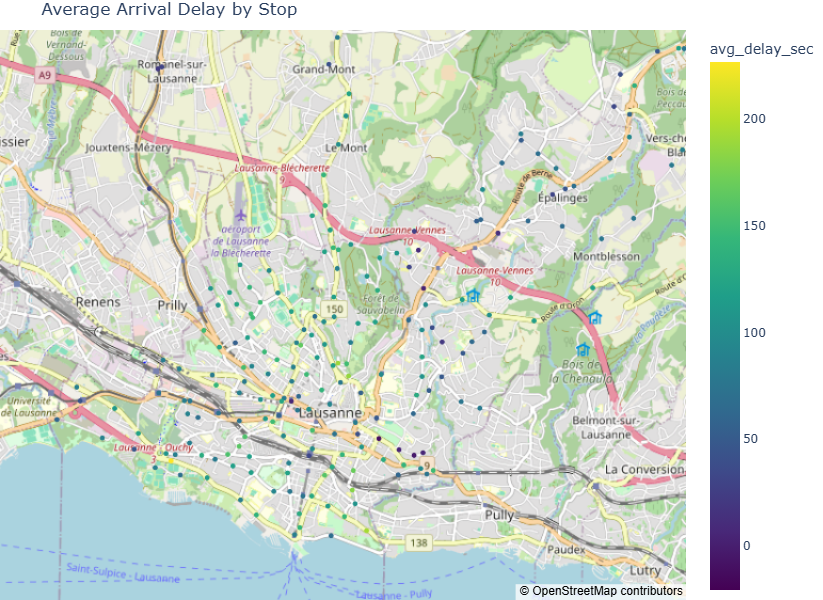

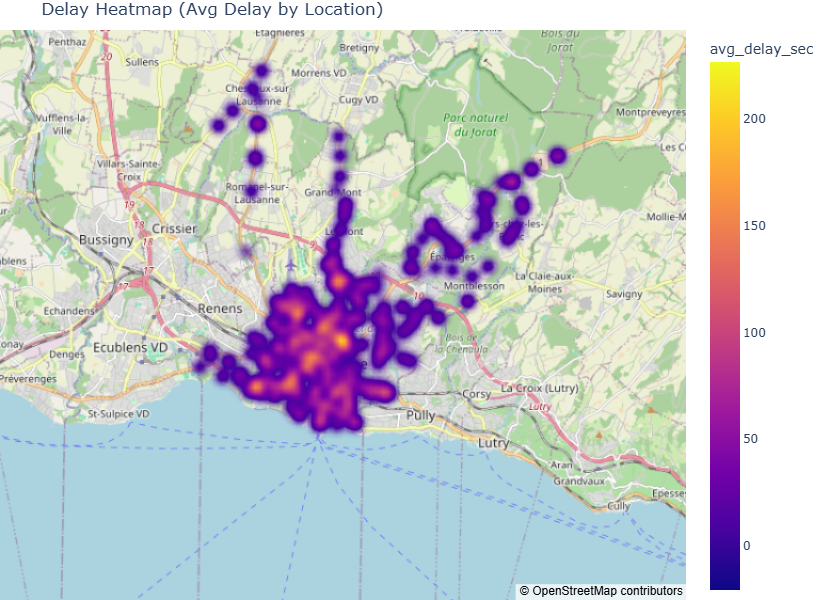

In [50]:
pdf_stops = stop_geo.toPandas()

fig_scatter = px.scatter_mapbox(
    pdf_stops,
    lat="latitude",
    lon="longitude",
    hover_name="stop_name",
    hover_data=["avg_delay_sec"],
    color="avg_delay_sec",
    color_continuous_scale="Viridis",
    size_max=50,
    zoom=12,
    mapbox_style="open-street-map",
    title="Average Arrival Delay by Stop",
    width=1000,
    height=600
)
fig_scatter.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig_scatter.show()


# Heatmap also square
fig_heat = px.density_mapbox(
    pdf_stops,
    lat="latitude",
    lon="longitude",
    z="avg_delay_sec",
    radius=15,
    center=dict(
       lat=pdf_stops["latitude"].mean(),
       lon=pdf_stops["longitude"].mean()
    ),
    zoom=11,
    mapbox_style="open-street-map",
    title="Delay Heatmap (Avg Delay by Location)",
    width=1000,
    height=600
)
fig_heat.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig_heat.show()

In [56]:
df_final = spark.read.option("header", True).csv(f"{hadoopFS}/user/com-490/group/U1/delays_with_weather")

df_final.show(1)

+-------------+---+----------------+-------+----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+
|operating_day|dow|         trip_id|stop_id|type|            arr_time|          arr_actual|            dep_time|          dep_actual|arr_delay_sec|dep_delay_sec|site|total_daily_precip|rained|
+-------------+---+----------------+-------+----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+
|   2024-08-23|  6|85:801:36029-287|8579245| Bus|2024-08-23T11:35:...|2024-08-23T11:37:...|2024-08-23T11:35:...|2024-08-23T11:37:...|          137|          161|LSGL|               0.0| false|
+-------------+---+----------------+-------+----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+
only showing top 1 row



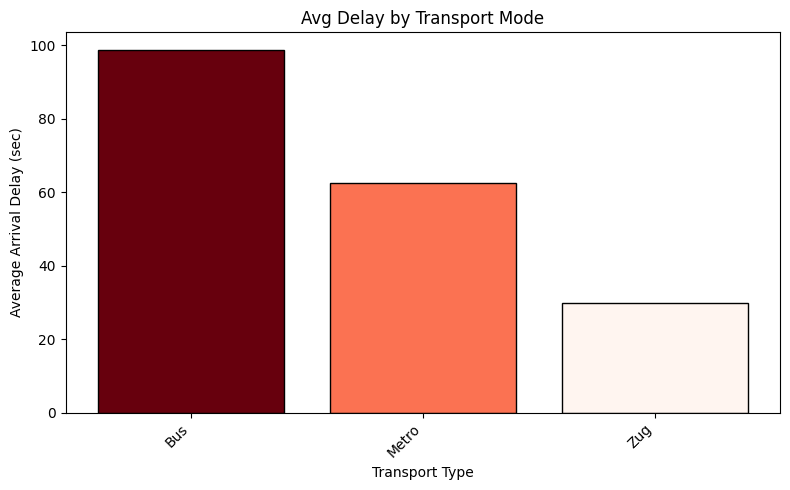

In [65]:
import matplotlib as mpl

# 1) Compute avg delay per transport type, dropping nulls
type_delay = (
    df_final
      .withColumn("arr_delay_sec", col("arr_delay_sec").cast("double"))
      .filter(col("type").isNotNull())
      .groupBy("type")
      .agg(round(avg("arr_delay_sec"),1).alias("avg_delay_sec"))
      .orderBy("type")
)

# 2) Move to Pandas
pdf_type = type_delay.toPandas()

# 3) Labels & values
labels = pdf_type["type"].astype(str).tolist()
values = pdf_type["avg_delay_sec"].tolist()

# 4) Build a Reds colormap based on delay
norm   = Normalize(vmin=min(values), vmax=max(values))
cmap   = mpl.colormaps["Reds"]
colors = cmap(norm(values))

# 5) Plot
plt.figure(figsize=(8,5))
plt.bar(
    labels,
    values,
    color=colors,
    edgecolor='black',   # <-- add this
    linewidth=1          # <-- and this
)
plt.xlabel("Transport Type")
plt.ylabel("Average Arrival Delay (sec)")
plt.title("Avg Delay by Transport Mode")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../figures/avg_delay_transportmode.png",dpi=300)
plt.show()

In [85]:
raw = spark.read.parquet(f"{hadoopFS}/user/com-490/group/U1/raw_df_modelling.parquet")

In [86]:
raw.show(1)

+-------+-------------+---+-----------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+---------------+--------------------+--------------------+
|stop_id|operating_day|dow|    trip_id| type|            arr_time|          arr_actual|            dep_time|          dep_actual|arr_delay_sec|dep_delay_sec|site|total_daily_precip|rained|      stop_name|            stop_lat|            stop_lon|
+-------+-------------+---+-----------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+---------------+--------------------+--------------------+
|8592133|   2024-12-11|  4|85:151:6479|Metro|2024-12-11T07:55:...|2024-12-11T07:57:...|2024-12-11T07:55:...|2024-12-11T07:58:...|          160|          194|LSGL|               0.0| false|Lausanne, Vigie|46.52153425000000...|6.623925380000000000|
+-------+---

In [87]:
df_final = raw.dropDuplicates()

In [88]:
df_final.show(10)

+-------+-------------+---+-----------+----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+--------------------+--------------------+--------------------+
|stop_id|operating_day|dow|    trip_id|type|            arr_time|          arr_actual|            dep_time|          dep_actual|arr_delay_sec|dep_delay_sec|site|total_daily_precip|rained|           stop_name|            stop_lat|            stop_lon|
+-------+-------------+---+-----------+----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+----+------------------+------+--------------------+--------------------+--------------------+
|8592103|   2024-12-09|  2|85:151:6207| Bus|2024-12-09T13:40:...|2024-12-09T13:40:...|2024-12-09T13:40:...|2024-12-09T13:41:...|           54|           77|LSGL|               0.0| false|Lausanne, Prélaz-...|46.52704755118700...|6.6068304378810000

In [82]:
df = df_final

df = (df
    .withColumn("delay_gt5min", (F.col("arr_delay_sec") > 300).cast("integer"))
    .withColumn("total_daily_precip", F.col("total_daily_precip").cast("double"))
    .fillna({"total_daily_precip": 0.0, "rained": "no"})
    .filter((F.col("arr_delay_sec") >= -600) & (F.col("arr_delay_sec") <= 2 * 3600))
    .withColumn("hour",  F.hour("arr_time"))
    .withColumn("month", F.month("arr_time"))
    .filter(F.col("dow").between(2, 6)))# keep only weekdays (Mon–Fri)


hist_w = (Window.partitionBy("stop_id").orderBy(F.col("operating_day").cast("timestamp")).rowsBetween(-7, -1))

df = (df.withColumn("hist7wd_delay_rate",F.avg("delay_gt5min").over(hist_w)).fillna({"hist7wd_delay_rate": 0.0}))

categorical_cols = ["stop_id", "site", "dow", "hour", "rained"]
numeric_cols     = ["total_daily_precip", "hist7wd_delay_rate"]


indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")  for c in categorical_cols]

encoders = [OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_ohe")for c in categorical_cols]

assembler = VectorAssembler(inputCols=[c + "_ohe" for c in categorical_cols] + numeric_cols, outputCol="features")

gbt = GBTClassifier(labelCol="delay_gt5min",featuresCol="features",
                    maxIter=30,maxDepth=6,stepSize=0.1,subsamplingRate=0.8,seed=42)

pipe = Pipeline(stages=indexers + encoders + [assembler, gbt])

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
model = pipe.fit(train_df)


In [84]:
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
    RegressionEvaluator
)

# 1) Generate predictions on your test set
preds = model.transform(test_df)

# 2) Peek at the key columns: 
#    - delay_gt5min: your true label (0/1)
#    - rawPrediction: internal GBT score vector
#    - probability: [P(0),P(1)]
#    - prediction: argmax(rawPrediction) → 0 or 1
preds.select(
    "delay_gt5min",
    "rawPrediction",
    "probability",
    "prediction"
).show(10, False)

# 3) Classification metrics

# 3a) Multiclass metrics: accuracy, F1, precision, recall
for metric in ["accuracy", "f1", "weightedPrecision", "weightedRecall"]:
    m = MulticlassClassificationEvaluator(
        labelCol="delay_gt5min",
        predictionCol="prediction",
        metricName=metric
    )
    print(f"{metric:>17} = {m.evaluate(preds):.4f}")

# 3b) AUC (binary ROC)
auc = BinaryClassificationEvaluator(
    labelCol="delay_gt5min",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
).evaluate(preds)
print(f"{'AUC (ROC)':>17} = {auc:.4f}")

# 4) (Optional) If you had used a regressor and want RMSE/MAE:
#    e.g. for arr_delay_sec
reg_e = RegressionEvaluator(
    labelCol="arr_delay_sec",
    predictionCol="prediction"    # or whatever your regression output column is
)
print("RMSE =", reg_e.evaluate(preds, {reg_e.metricName: "rmse"}))
print(" MAE =", reg_e.evaluate(preds, {reg_e.metricName: "mae"}))

+------------+----------------------------------------+----------------------------------------+----------+
|delay_gt5min|rawPrediction                           |probability                             |prediction|
+------------+----------------------------------------+----------------------------------------+----------+
|0           |[1.2483652611406053,-1.2483652611406053]|[0.9239122993626219,0.07608770063737813]|0.0       |
|0           |[1.2483652611406053,-1.2483652611406053]|[0.9239122993626219,0.07608770063737813]|0.0       |
|0           |[1.2483652611406053,-1.2483652611406053]|[0.9239122993626219,0.07608770063737813]|0.0       |
|0           |[1.5083882549833598,-1.5083882549833598]|[0.9533263048651643,0.04667369513483566]|0.0       |
|0           |[1.3633913273850435,-1.3633913273850435]|[0.9385886508905984,0.0614113491094016] |0.0       |
|0           |[1.3633913273850435,-1.3633913273850435]|[0.9385886508905984,0.0614113491094016] |0.0       |
|0           |[1.36339132738

         accuracy = 0.9104


               f1 = 0.8709


weightedPrecision = 0.8809


   weightedRecall = 0.9104


        AUC (ROC) = 0.7293


IllegalArgumentException: requirement failed: Column arr_delay_sec must be of type numeric but was actually of type string.

In [89]:
from pyspark.sql.types    import DoubleType, IntegerType, DateType
from pyspark.sql.functions import (
    to_timestamp, unix_timestamp, col,
    hour, month, when, avg
)
from pyspark.sql.window   import Window
from pyspark.ml            import Pipeline
from pyspark.ml.feature    import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import GBTClassifier

# 0) start from your loaded df_final
df = df_final

# 1) cast & parse
df = (df
  # cast your true delay to double
  .withColumn("arr_delay_sec", col("arr_delay_sec").cast(DoubleType()))
  # parse arr_time as timestamp so hour/month work
  .withColumn("arr_time_ts", to_timestamp("arr_time"))
  # cast precip
  .withColumn("total_daily_precip", col("total_daily_precip").cast(DoubleType()))
  # cast dow (if it was string) to int so between(2,6) works
  .withColumn("dow", col("dow").cast(IntegerType()))
)

# 2) label + filters + time features
df = (df
  # binary label: >5min late?
  .withColumn("delay_gt5min", (col("arr_delay_sec") > 300).cast(IntegerType()))
  # drop outliers
  .filter((col("arr_delay_sec") >= -600) & (col("arr_delay_sec") <= 7200))
  # fill missing weather flags
  .fillna({"total_daily_precip": 0.0, "rained": "no"})
  # extract hour & month
  .withColumn("hour",  hour("arr_time_ts"))
  .withColumn("month", month("arr_time_ts"))
  # restrict to Mon–Fri
  .filter(col("dow").between(2, 6))
)

# 3) 7-day rolling “delay rate” per stop
hist_w = (Window
  .partitionBy("stop_id")
  .orderBy(col("operating_day").cast("timestamp"))
  .rowsBetween(-7, -1)
)
df = df.withColumn(
    "hist7wd_delay_rate",
    avg("delay_gt5min").over(hist_w)
).fillna({"hist7wd_delay_rate": 0.0})

# 4) define your feature columns—and now INCLUDE 'type' & 'stop_name'
categorical_cols = ["stop_id", "site", "dow", "hour", "rained", "type", "stop_name"]
numeric_cols     = ["total_daily_precip", "hist7wd_delay_rate"]

# 5) indexers + one-hots
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")
    for c in categorical_cols
]
encoders = [
    OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_ohe")
    for c in categorical_cols
]

# 6) assemble into ‘features’
assembler = VectorAssembler(
    inputCols=[c + "_ohe" for c in categorical_cols] + numeric_cols,
    outputCol="features"
)

# 7) GBTClassifier
gbt = GBTClassifier(
    labelCol="delay_gt5min",
    featuresCol="features",
    maxIter=30,
    maxDepth=6,
    stepSize=0.1,
    subsamplingRate=0.8,
    seed=42,
    maxBins=256
)

# 8) pipeline + train/test split
pipeline = Pipeline(stages=indexers + encoders + [assembler, gbt])
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_df)

# 9) get predictions & inspect
preds = model.transform(test_df)


+-------+-------------+---+-----------+----+-----------------------+-----------------------+-----------------------+-----------------------+-------------+-------------+----+------------------+------+-------------------+---------------------+--------------------+-------------------+------------+----+-----+-------------------+-----------+--------+-------+--------+----------+--------+-------------+-----------------+-------------+-------------+---------------+-------------+-------------+-----------------+-----------------------------------------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|stop_id|operating_day|dow|trip_id    |type|arr_time               |arr_actual             |dep_time               |dep_actual             |arr_delay_sec|dep_delay_sec|site|total_daily_precip|rained|stop_name          |stop_lat             |stop_lon            |arr_time_ts        |delay_gt5min|hour|month|hist

In [103]:
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
    RegressionEvaluator
)
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, when, sum as spark_sum
from pyspark.sql.types import DoubleType

# assume `preds` is your DataFrame from model.transform(test_df)

# 0) Extract P(class=1) into prob1
preds = preds.withColumn("prob1", vector_to_array("probability")[1])

# 1) Standard multiclass metrics on the 0/1 prediction
mc = MulticlassClassificationEvaluator(
    labelCol="delay_gt5min", predictionCol="prediction"
)
for metric in ["accuracy", "f1", "weightedPrecision", "weightedRecall"]:
    print(f"{metric:>17} = {mc.setMetricName(metric).evaluate(preds):.4f}")

# Binary AUC metrics
bin = BinaryClassificationEvaluator(
    labelCol="delay_gt5min", rawPredictionCol="rawPrediction"
)
print(f"{'AUC (ROC)':>17} = {bin.setMetricName('areaUnderROC').evaluate(preds):.4f}")
print(f"{'AUC (PR)':>17} = {bin.setMetricName('areaUnderPR').evaluate(preds):.4f}")

# 3) Confusion matrix at threshold=0.5
cm = preds.withColumn("tp", when((col("delay_gt5min")==1)&(col("prediction")==1),1).otherwise(0)) \
          .withColumn("tn", when((col("delay_gt5min")==0)&(col("prediction")==0),1).otherwise(0)) \
          .withColumn("fp", when((col("delay_gt5min")==0)&(col("prediction")==1),1).otherwise(0)) \
          .withColumn("fn", when((col("delay_gt5min")==1)&(col("prediction")==0),1).otherwise(0))

counts = cm.select(
    spark_sum("tp").alias("TP"),
    spark_sum("tn").alias("TN"),
    spark_sum("fp").alias("FP"),
    spark_sum("fn").alias("FN")
).collect()[0].asDict()

print("\nConfusion Matrix (0.5):")
print(f"  TP: {counts['TP']},  FP: {counts['FP']}")
print(f"  FN: {counts['FN']},  TN: {counts['TN']}")

# Precision/Recall at multiple thresholds
print("\nThreshold sweep:")
for t in [0.3, 0.5, 0.7]:
    preds_thresh = preds.withColumn(
        "pred_th",
        when(col("prob1") >= t, 1.0).otherwise(0.0)  # cast to double here
    )
    prec = mc.setMetricName("weightedPrecision")\
             .setPredictionCol("pred_th")\
             .evaluate(preds_thresh)
    rec  = mc.setMetricName("weightedRecall")\
             .setPredictionCol("pred_th")\
             .evaluate(preds_thresh)
    print(f"  thresh={t:.1f}  →  precision={prec:.4f}, recall={rec:.4f}")


         accuracy = 0.9103


               f1 = 0.8700


weightedPrecision = 0.8825


   weightedRecall = 0.9103


        AUC (ROC) = 0.7323


         AUC (PR) = 0.2495



Confusion Matrix (0.5):
  TP: 4343,  FP: 3022
  FN: 242406,  TN: 2486022

Threshold sweep:


  thresh=0.3  →  precision=0.8736, recall=0.9053


  thresh=0.5  →  precision=0.8829, recall=0.9103


  thresh=0.7  →  precision=0.8917, recall=0.9098


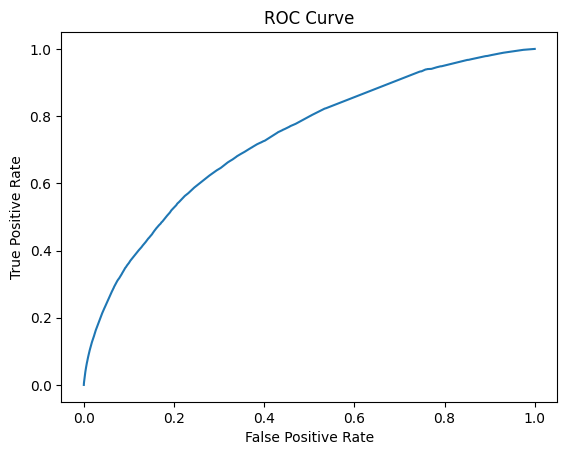

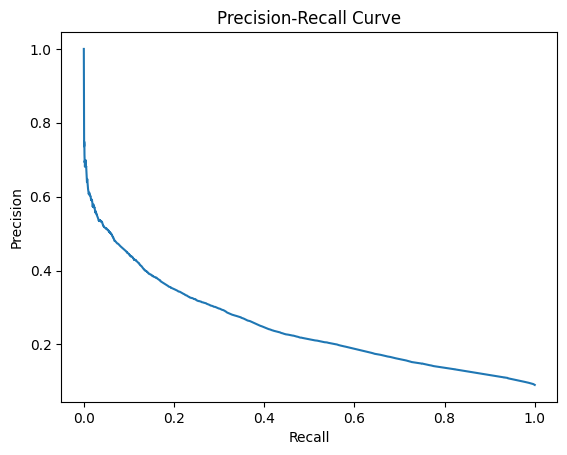

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
import pandas as pd

pdf = preds.select("delay_gt5min", "probability").toPandas()
pdf["prob1"] = pdf["probability"].apply(lambda v: v[1])

y = pdf["delay_gt5min"]
scores = pdf["prob1"]

fpr, tpr, _ = roc_curve(y, scores)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
